## Plot train/test error across different models/n train frames

In [1]:
import hydra
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import torch
from omegaconf import DictConfig

from lightning_pose.utils.io import return_absolute_data_paths
# from lightning_pose.utils.pca import KeypointPCA, compute_pca_reprojection_error
# from lightning_pose.utils.predictions import predict_dataset
from lightning_pose.utils.scripts import get_imgaug_transform, get_dataset, get_data_module, get_loss_factories
from lightning_pose.losses.losses import PCALoss

import sys
sys.path.append('/home/jovyan/tracking-diagnostics')
from diagnostics.handler import ModelHandler

In [2]:
def get_base_config(config_dir: str, config_name: str) -> DictConfig:
    assert(os.path.isdir(config_dir))
    hydra.initialize_config_dir(base_config_dir)
    cfg = hydra.compose(config_name="config")
    return cfg
    

In [3]:
from typing import List
def get_keypoint_names(csv_data: pd.DataFrame, header_rows: List[int]) -> List[str]:
    if header_rows == [0,1,2]:
        keypoint_names = [c[1] for c in csv_data.columns[1::2]]
    elif header_rows == [1,2]:
        keypoint_names = [c[0] for c in csv_data.columns[1::2]]
    return keypoint_names
# test for rick
# keypoint_names = get_keypoint_names(csv_data, cfg.data.header_rows)
# assert(len(get_keypoint_names(csv_data, cfg.data.header_rows))==17)

### define configuration

In [4]:
dataset_name = "rick-configs-1"
# dataset_name = "ibl-pupil-2"
# dataset_name = "ibl-paw-2"
base_config_dir = "/home/jovyan/rick-configs-1"
base_save_dir = "/home/jovyan/"

# hydra.initialize_config_dir(base_config_dir)
# cfg = hydra.compose(config_name="config")
cfg = get_base_config(base_config_dir, "config")

# load ground truth labels
csv_file = os.path.join(cfg.data.data_dir, cfg.data.csv_file)
csv_data = pd.read_csv(csv_file, header=list(cfg.data.header_rows))
keypoints_gt = csv_data.iloc[:, 1:].to_numpy().reshape(csv_data.shape[0], -1, 2)

keypoint_names = get_keypoint_names(csv_data, cfg.data.header_rows)

# if cfg.data.header_rows == [0,1,2]:
#     keypoint_names = [c[1] for c in csv_data.columns[1::2]]
# elif cfg.data.header_rows == [1,2]:
#     keypoint_names = [c[0] for c in csv_data.columns[1::2]]

What do we want to search over? be more faithful to the actual hydra structure so it's easy to search
have model groups. each group may have completely different parameters. including modelname etc. so can have a dict of dicts. 
the quantities to compute are a separate issue. we just need to get the model handlers.
each model is copying the config and overwriting it with command line args. so each one will be like {["data"]: 6} or something like that.

In [8]:
# save_dir = os.path.join(base_save_dir, dataset_name)
save_dir = "/home/jovyan/lightning-pose"

loss_type = "pca_singleview" # Change for different loss functions
error_metric = "reprojection_error" # for pca only
# define models
to_compute = "rmse" # rmse | pca_multiview | pca_singleview | unimodal_mse
model_name = "temporal-heatmap"
train_frames = 75 # 000
#pca_singleview_epsilon = 15.
#pca_multiview_epsilon = None
#empirical_epsilon_multiplier = 1.0 # can hack this if want to sweep over multipliers/losses
model_type = "heatmap"
#rng_seed = 42
# temporal_epsilon = 9.8 # hack for now

loss_weight_dict = {
    'supervised': [None],#[11.5],
    #'temporal': [7.5],#[6.0,6.5,7.0,7.25,7.50,8.0,11.5],
    #'unimodal_mse': [1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.5,5.75,6.0,6.5,7.0,7.25,7.5,7.75,8.0,8.25,9.0,11.5],
    'pca_singleview': [7.25]#[7.0,7.25,7.5,7.75,8.0,11.5],# was [6.5,6.75,7.0,7.25,7.5,8.0,11.5], # Hacking. this is epsilon
    #'pca_multiview': [1.0,1.25,1.5,2.0,4.0]# <-hack for now, [7.0,7.5,10.5] #<- actual log weights. #[1.0,1.5,2.0,3.0] <-hack for now, it's not weight, it's empirical epsilon multiplier, #[2.0, 1.0, 0.0, -1.0],

}
loss_weight_dict['temporal'].sort(reverse=True)
#loss_weight_dict['pca_singleview'].sort(reverse=True)

pca_loss = None
datamodule = None
model_cfg = cfg.copy()
model_cfg.training.train_frames = train_frames
model_cfg.model.losses_to_use = [loss_type]
if to_compute == 'rmse':
    y_label = 'RMSE per bodypart'
elif to_compute == 'pca_multiview' or to_compute == 'pca_singleview':
    y_label = 'PCA reprojection error'
    from lightning_pose.utils.pca import KeypointPCA
    data_dir, video_dir = return_absolute_data_paths(data_cfg=model_cfg.data)
    imgaug_transform = get_imgaug_transform(cfg=model_cfg)
    dataset = get_dataset(cfg=model_cfg, data_dir=data_dir, imgaug_transform=imgaug_transform)
    data_module = get_data_module(cfg=model_cfg, dataset=dataset, video_dir=video_dir)
    data_module.setup()
    # compute pca params
    loss_factories = get_loss_factories(cfg=model_cfg, data_module=data_module)
    pca_loss = loss_factories["unsupervised"].loss_instance_dict[loss_type]
    #pca_loss = PCALoss(loss_name=loss_type, loss_weight=1.0, loss_weight_dict=loss_weight_dict, empirical_epsilon_multiplier=empirical_epsilon_multiplier)
    #pca_obj = KeypointPCA(loss_type=loss_type, error_metric=error_metric, data_module=data_module, mirrored_column_matches=model_cfg.data.mirrored_column_matches, columns_for_singleview_pca=model_cfg.data.columns_for_singleview_pca)
    #pca_obj()
elif to_compute == 'unimodal_mse':
    y_label = 'Unimodal MSE'
elif to_compute == 'temporal_norm':
    raise NotImplementedError
    
# store results here
if to_compute == "pca_singleview":
    # remove obstacle keypoints
    keypoint_names = [kp for kp in keypoint_names if kp not in ['obs_top','obsHigh_bot','obsLow_bot']]
    print(keypoint_names)

metrics_collected = {bp: [] for bp in keypoint_names}
cols_collected = []

# loop over models and compute metric of interest
for loss_type, loss_weights in loss_weight_dict.items():
    for loss_weight in loss_weights:

        # find model checkpoint
        model_cfg = cfg.copy()
        model_cfg.training.train_frames = train_frames
        # Dan -- edit the below with numbers
        model_cfg.training.rng_seed_data_pt = 42
        model_cfg.training.rng_seed_data_dali = 42
        model_cfg.training.rng_seed_model_pt = 42
        model_cfg.model.model_name = model_name
        model_cfg.model.model_type = model_type

        # put model-specific config info here
        if loss_type == 'supervised': # edits above are because of our use of 10.5 weight for the "supervised" loss
            model_cfg.model.model_name =  "supervised-heatmap-75" # "pca-singleview-heatmap" # was "supervised_50"
            model_cfg.model.losses_to_use = [] # ["pca_singleview"] # was None
            # hacks below
            # model_cfg.losses["pca_singleview"].log_weight = loss_weight #  <- TODO: just hack for now, should be loss_weight
             #model_cfg.losses["pca_singleview"].empirical_epsilon_multiplier = empirical_epsilon_multiplier # TODO: warning, it's a hack. should be empirical_epsilon_multiplier

        else:
            model_cfg.model.losses_to_use = [loss_type]
            model_cfg.losses[loss_type].log_weight = loss_weight # 
            model_cfg.losses[loss_type].epsilon = 1.0 #empirical_epsilon_multiplier # TODO: hack; was pca_multiview_epsilon
            # model_cfg.losses[loss_type].empirical_epsilon_multiplier = empirical_epsilon_multiplier # TODO: warning, it's a hack. should be empirical_epsilon_multiplier
#                 print(model_cfg.losses)
            if loss_type in ["pca_multiview","pca_singleview"]:
                model_cfg.losses[loss_type].error_metric = error_metric

        try:
            print(save_dir)
            handler = ModelHandler(save_dir, model_cfg, verbose=True)
        except FileNotFoundError:
            print('did not find %s model for train_frames=%i' % (loss_type, train_frames))
            continue

        try:
            result = handler.compute_metric(
                to_compute, 'predictions.csv',
                keypoints_true=keypoints_gt, pca_loss_obj=pca_loss, datamodule=datamodule)
            print(result.shape)
        except FileNotFoundError:
            print('could not find model predictions')
            continue

        if loss_type == 'supervised':
            for loss_type_, loss_weights_ in loss_weight_dict.items():
                if loss_type_ == 'supervised':
                    # make a supervised entry, but not under this name
                    continue
                else:
                    cols_collected.append('%s_s' % loss_type_)
                    for b, bodypart in enumerate(keypoint_names):
                        metrics_collected[bodypart].append(result[:, b])
        else:
            #if len(loss_weight.split('.')[-1]) == 1:
            cols_collected.append('%s_%s' % (loss_type, loss_weight))
            #cols_collected.append('%s_%.1f' % (loss_type, loss_weight))
            for b, bodypart in enumerate(keypoint_names):
                metrics_collected[bodypart].append(result[:, b])

# collect results                
results_df = []
for bodypart in keypoint_names:
    dict_tmp = {
        'bodypart': bodypart,
        #'rng_seed': rng_seed,
        'eval_mode': handler.pred_df.iloc[:, -1].to_numpy(),
        'img_file': handler.pred_df.iloc[:, 0], # TODO: fix, this is wrong. should be a str not a float
    }
    for col_name, metric in zip(cols_collected, metrics_collected[bodypart]):
        dict_tmp[col_name] = metric
    results_df.append(pd.DataFrame(dict_tmp))

results_df = pd.concat(results_df)

/home/jovyan/lightning-pose
/home/jovyan/lightning-pose/multirun/2022-03-26/22-44-51/2
unmatched keys: [current vs requested]
model_name: pca-singleview-heatmap vs supervised-heatmap-75
losses_to_use: ['pca_singleview'] vs []

/home/jovyan/lightning-pose/multirun/2022-03-26/22-44-51/4
unmatched keys: [current vs requested]
model_name: pca-singleview-heatmap vs supervised-heatmap-75
losses_to_use: ['pca_singleview'] vs []

/home/jovyan/lightning-pose/multirun/2022-03-26/22-44-51/0
unmatched keys: [current vs requested]
model_name: pca-singleview-heatmap vs supervised-heatmap-75
losses_to_use: ['pca_singleview'] vs []

/home/jovyan/lightning-pose/multirun/2022-03-26/22-44-51/1
unmatched keys: [current vs requested]
model_name: pca-singleview-heatmap vs supervised-heatmap-75
losses_to_use: ['pca_singleview'] vs []

/home/jovyan/lightning-pose/multirun/2022-03-26/22-44-51/3
unmatched keys: [current vs requested]
model_name: pca-singleview-heatmap vs supervised-heatmap-75
losses_to_use: ['p

In [9]:
cols_collected

['temporal_s', 'temporal_7.5']

In [49]:
if to_compute == "pca_multiview":
    # assert nans where we think they should be
    assert(~np.any(np.isnan(result[:, np.arange(7)])))
    assert(~np.any(np.isnan(result[:, np.arange(8,15)])))
    assert(np.all(np.isnan(result[:, np.arange(15, 34)])))

In [9]:
results_df.head()

,bodypart,eval_mode,img_file,temporal_s,temporal_11.5,temporal_8.0,temporal_7.5,temporal_7.25,temporal_7.0,temporal_6.5,temporal_6.0
0,paw1LH_top,unused,175.405749,4.904104,6.134691,5.750355,30.489620,39.020999,13.163246,75.533897,75.533795
1,paw1LH_top,unused,136.353965,23.247594,21.761527,16.695194,20.861797,12.802017,46.391288,72.375565,71.189566
2,paw1LH_top,unused,143.178085,4.094948,68.835028,10.318268,4.325853,4.514929,16.568459,15.664136,16.507220
3,paw1LH_top,unused,140.031782,1.934759,3.133205,2.113862,4.270044,3.035415,7.375375,8.926817,13.263354
4,paw1LH_top,unused,74.596274,6.839704,5.684921,6.427734,5.460636,4.978482,6.372097,49.861247,6.599231


### scatterplots for a pair of models

In [ ]:
sns.set_context('talk')
sns.set_style('whitegrid')

eval_mode = 'train'

fig = px.scatter(
    results_df[results_df.eval_mode==eval_mode], 
    # x='unimodal_mse_0', y='unimodal_mse_5.0',
    x='pca_multiview_7.0', y='pca_multiview_10.5',
    facet_col='bodypart',
    facet_col_wrap=3,
    hover_data=['img_file'],
    log_x=True,
    log_y=True,
    opacity=0.5,
#     trendline="ols",
    title='%s on %s data' % (y_label, eval_mode),
)
# draw a diagonal line
fig.update_traces(marker={'size': 5})

# if dataset_name == 'ibl-paw-2':
#     if to_compute == 'unimodal_mse':
#         mn, mx = 0.0001, 0.01
#     else:
#         mn, mx = 0.1, 80
# elif dataset_name == 'ibl-pupil-2':
#     if to_compute == 'unimodal_mse':
#         mn, mx = 0.0004, 0.005
#     else:
#         mn, mx = 0.1, 10
# elif dataset_name == 'ibl-fingers':
#     if to_compute == 'rmse':
#         mn, mx = 2, 40
#     if to_compute == 'pca_reproj':
#         mn, mx = 2, 40
# trace = go.Scatter(x=[mn, mx], y=[mn, mx], line_color="black", mode="lines")
# trace.update(legendgroup="trendline", showlegend=False)
# fig.add_trace(trace, row="all", col="all", exclude_empty_subplots=True)
fig.update_layout(width=800, height=1200)

fig.show()

### barplots across all models

In [10]:
df_tmp = pd.melt(
    results_df, 
    id_vars=['bodypart', 'img_file', 'eval_mode'], 
    value_vars=cols_collected
)
def add_loss_name_col(row):
    return '_'.join(row['variable'].split('_')[:-1])
def add_loss_val_col(row):
    return row['variable'].split('_')[-1]
df_tmp['loss'] = df_tmp.apply(add_loss_name_col, axis=1)
df_tmp['loss_weight'] = df_tmp.apply(add_loss_val_col, axis=1)

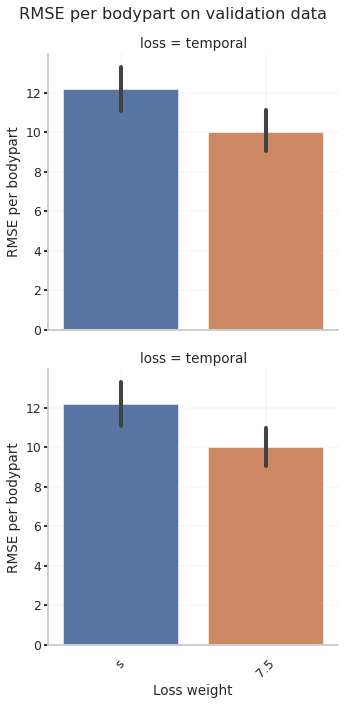

In [13]:
sns.set(context='talk', style='whitegrid', font_scale=0.75)

eval_mode = 'validation'

num_losses_to_plot = 16 #len(cols_collected) # can exclude vals here
# average over keypoints and frames
df_tmp_ = df_tmp[df_tmp.eval_mode==eval_mode]
g = sns.catplot(
    x='loss_weight', y='value', 
    #log=False,
    order=['s'] + [str(w) for w in loss_weight_dict['temporal'][:num_losses_to_plot]],
    #kind='strip', dodge=True,
    kind='bar',
    col='loss',
    col_wrap=np.min([len(df_tmp_.loss.unique()), 3]), 
    data=df_tmp_,
    col_order=['temporal', 'temporal'],
#     col='bodypart',
#     sharey=False,
#     data=df_tmp_[df_tmp_.loss=='pca_singleview'],
)
g.set_axis_labels('Loss weight', y_label)
g.set_xticklabels(rotation=45, ha='center')

for ax in g.axes.flatten():
    ax.tick_params(axis='y', which='both', direction='out', length=4, left=True)
    ax.grid(b=True, which='both', color='gray', linewidth=0.1)

# if dataset_name == 'ibl-paw-2':
#     if to_compute == 'pca_reproj':
#         if eval_mode == 'unused':
#             g.set(ylim=[3.8, 4.8])
#         elif eval_mode == 'validation':
#             g.set(ylim=[4, 5.7])
#         elif eval_mode == 'train':
#             g.set(ylim=[4, 5.5])
# elif dataset_name == 'ibl-pupil-2':
#     if to_compute == 'rmse':
#         if eval_mode == 'validation':
#             g.set(ylim=[1.5, 2.4])
# #     if to_compute == 'unimodal_mse':
# #         g.set(ylim=[0.008, .015])
# elif dataset_name == 'ibl-fingers':
#     if to_compute == 'rmse':
#         if eval_mode == 'train':
#             g.set(ylim=[7, 14])
#         elif eval_mode == 'validation':
#             g.set(ylim=[10, 20])
#         elif eval_mode == 'test':
#             g.set(ylim=[14, 20])
#     elif to_compute == 'pca_reproj':
#         if eval_mode == 'test':
#             g.set(ylim=[12, 14.4])
            
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('%s on %s data' % (y_label, eval_mode))
plt.tight_layout()
plt.show()

In [25]:
import yaml
from omegaconf import OmegaConf
# loop over models with a specific hydra path and name. compare to supervised as in above
hydra_paths = ["/home/jovyan/lightning-pose/multirun/2022-03-29/19-03-32/0/.hydra/config.yaml", "/home/jovyan/lightning-pose/multirun/2022-03-29/19-15-30/0/.hydra/config.yaml"]
save_dir = "/home/jovyan/lightning-pose"
out = [os.path.isfile(p) for p in hydra_paths]
assert all(out)
# read the config files and feed them to handler
configs = [yaml.load(open(p, 'r')) for p in hydra_paths]
print(configs[0])
for model_cfg in configs:
    try: 
        handler = ModelHandler(save_dir, model_cfg, verbose=True)
    except FileNotFoundError:
        print('Model not found')
        continue
#  try:
#             print(save_dir)
#             handler = ModelHandler(save_dir, model_cfg, verbose=True)
#         except FileNotFoundError:
#             print('did not find %s model for train_frames=%i' % (loss_type, train_frames))
#             continue


{'training': {'train_batch_size': 16, 'val_batch_size': 16, 'test_batch_size': 16, 'train_prob': 0.8, 'val_prob': 0.1, 'train_frames': 75, 'num_gpus': 0, 'num_workers': 8, 'early_stop_patience': 3, 'unfreezing_epoch': 25, 'dropout_rate': 0.1, 'min_epochs': 125, 'max_epochs': 1000, 'log_every_n_steps': 1, 'check_val_every_n_epoch': 10, 'gpu_id': 0, 'unlabeled_sequence_length': 16, 'rng_seed_data_pt': 42, 'rng_seed_data_dali': 42, 'rng_seed_model_pt': 42, 'limit_train_batches': 10, 'multiple_trainloader_mode': 'max_size_cycle', 'profiler': 'simple', 'accumulate_grad_batches': 2, 'lr_scheduler': 'multisteplr', 'lr_scheduler_params': {'multisteplr': {'milestones': [100, 200, 300], 'gamma': 0.5}}}, 'losses': {'pca_multiview': {'log_weight': 7.0, 'components_to_keep': 3, 'empirical_epsilon_percentile': 1.0, 'empirical_epsilon_multiplier': 1.0, 'epsilon': None, 'error_metric': 'reprojection_error'}, 'pca_singleview': {'log_weight': 7.25, 'components_to_keep': 0.99, 'empirical_epsilon_percenti

/tmp/ipykernel_13035/1730997470.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  configs = [yaml.load(open(p, 'r')) for p in hydra_paths]


AttributeError: 'dict' object has no attribute 'model'

AttributeError: 'Line2D' object has no property 'col_wrap'

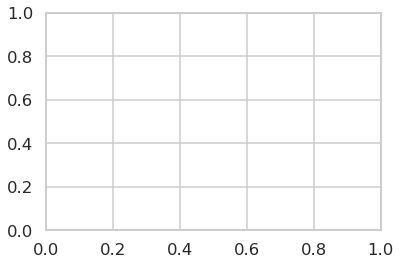

In [16]:
sns.set(context='talk', style='whitegrid', font_scale=1)

eval_mode = 'test'
log = False

# average over keypoints and frames
# filter weird bps
df_tmp = df_tmp[~df_tmp["bodypart"].isin(["obsLow_bot", "obsHigh_bot", "obs_top"])]
# select eval mode
df_tmp_ = df_tmp[df_tmp.eval_mode==eval_mode]
if log:
    df_tmp_['value'] = np.log(df_tmp_['value'])
g = sns.boxenplot(
    y='loss_weight', x='value', # switched these around for horizontal boxenplot
    order=['s'] + [str(w) for w in loss_weight_dict['temporal']], # was loss_weight_dict['pca_singleview']
#     kind='strip', dodge=True,
    data=df_tmp_, 
    orient="h",
)
print("bodyparts included: {}".format(pd.unique(df_tmp_.bodypart)))

In [6]:
# extracting a shorter clip
import fiftyone as fo
import fiftyone.utils.video as fouv
import os
orig_video_path = "/datastores/mouseRunningData/unlabeled_videos/180727_001.mp4"
new_clip_path = "/home/jovyan/clips/180727_001.mp4"
fouv.extract_clip(orig_video_path, new_clip_path, support=[10000, 11000], timestamps=None, fast=False)

In [10]:
### Finding models with a specific hydra path and name. compare to supervised as in above
losses_to_use = ["pca_singleview"] # Change for different loss functions
error_metric = "reprojection_error" # for pca only
# define models
model_name = "pca-singleview-heatmap-new"
train_frames = 75 # 000
error_metric = "reprojection_error"
#pca_singleview_epsilon = 15.
#pca_multiview_epsilon = None
#empirical_epsilon_multiplier = 1.0 # can hack this if want to sweep over multipliers/losses
model_type = "heatmap"
#rng_seed = 42
# temporal_epsilon = 9.8 # hack for now

loss_weight_dict = {
    'supervised': [None],#[11.5],
    #'temporal': [7.5],#[6.0,6.5,7.0,7.25,7.50,8.0,11.5],
    #'unimodal_mse': [1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.5,5.75,6.0,6.5,7.0,7.25,7.5,7.75,8.0,8.25,9.0,11.5],
    'pca_singleview': [7.25]#[7.0,7.25,7.5,7.75,8.0,11.5],# was [6.5,6.75,7.0,7.25,7.5,8.0,11.5], # Hacking. this is epsilon
    #'pca_multiview': [1.0,1.25,1.5,2.0,4.0]# <-hack for now, [7.0,7.5,10.5] #<- actual log weights. #[1.0,1.5,2.0,3.0] <-hack for now, it's not weight, it's empirical epsilon multiplier, #[2.0, 1.0, 0.0, -1.0],

}
save_dir = "/home/jovyan/lightning-pose"

# loop over models and compute metric of interest
for loss_type, loss_weights in loss_weight_dict.items():
    for loss_weight in loss_weights:

        model_cfg = cfg.copy()
        model_cfg.training.train_frames = train_frames
        model_cfg.model.losses_to_use = [loss_type]
        model_cfg.model.model_name = model_name
        model_cfg.model.model_type = model_type

        # put model-specific config info here
        if loss_type == 'supervised': # edits above are because of our use of 10.5 weight for the "supervised" loss
            model_cfg.model.model_name =  "supervised-heatmap-75" # "pca-singleview-heatmap" # was "supervised_50"
            model_cfg.model.losses_to_use = [] # ["pca_singleview"] # was None
            # hacks below
            # model_cfg.losses["pca_singleview"].log_weight = loss_weight #  <- TODO: just hack for now, should be loss_weight
             #model_cfg.losses["pca_singleview"].empirical_epsilon_multiplier = empirical_epsilon_multiplier # TODO: warning, it's a hack. should be empirical_epsilon_multiplier

        else:
            model_cfg.model.losses_to_use = [loss_type]
            model_cfg.losses[loss_type].log_weight = loss_weight # 
            model_cfg.losses[loss_type].empirical_epsilon_multiplier = 1.0 #empirical_epsilon_multiplier # TODO: hack; was pca_multiview_epsilon
            # model_cfg.losses[loss_type].empirical_epsilon_multiplier = empirical_epsilon_multiplier # TODO: warning, it's a hack. should be empirical_epsilon_multiplier
#                 print(model_cfg.losses)
            if loss_type in ["pca_multiview","pca_singleview"]:
                model_cfg.losses[loss_type].error_metric = error_metric

        try:
            handler = ModelHandler(save_dir, model_cfg, verbose=False)
            print("{}:".format(model_cfg.model.model_name))
            print(handler.model_dir)
        except FileNotFoundError:
            print('did not find %s model for train_frames=%i' % (loss_type, train_frames))
            continue


supervised-heatmap-75:
/home/jovyan/lightning-pose/multirun/2022-03-27/01-17-25/0
pca-singleview-heatmap-new:
/home/jovyan/lightning-pose/multirun/2022-03-28/15-20-58/1


## Looping over loss types

In [14]:
save_dir = "/home/jovyan/lightning-pose"
loss_types = [[],["pca_singleview"], ["temporal","pca_singleview"], ["temporal","pca_multiview"], ["temporal","unimodal_mse"],["temporal","unimodal_mse","pca_singleview"],["temporal","unimodal_mse","pca_multiview"],["temporal","unimodal_mse","pca_multiview","pca_singleview"],["pca_singleview","pca_multiview"],["unimodal_mse", "pca_singleview", "pca_multiview"],["temporal", "pca_singleview", "pca_multiview"],["unimodal_mse","pca_multiview"],["unimodal_mse","pca_singleview"]] # TODO: order matters
log_weight_list = [] # [[], [7.25], [7.5, 7.25]] # TODO: order matters
model_names = ["supervised-heatmap-75", "pca-singleview-heatmap-new", "temporal-pca_singleview-heatmap", "temporal-pca_multiview-heatmap", *["heatmap_75_loss_type_sweep"]*9 ]
supervised_model_name = "supervised-heatmap-75"
train_frames = 75
model_type = "heatmap"
handlers = []
for loss_idx, loss in enumerate(loss_types):
    print(loss)
    model_cfg = cfg.copy()
    model_cfg.training.train_frames = train_frames
    model_cfg.model.losses_to_use = loss # assume loss is already a list, [] f
    model_cfg.model.model_name = model_names[loss_idx]
    model_cfg.model.model_type = model_type
    if len(loss) == 0:
        model_cfg.model.model_name = supervised_model_name
    else:
        # loop over the sub losses
        if len(log_weight_list)>0:
            for sub_loss_idx,sub_loss in enumerate(loss):
                model_cfg.losses[sub_loss].log_weight = log_weight_list[loss_idx][sub_loss_idx]
    
    try:
        handlers.append(ModelHandler(save_dir, model_cfg, verbose=False))
        print("Found: {}".format(model_cfg.model.model_name))
        print("In: {}".format(handlers[-1].model_dir))
    except FileNotFoundError:
        print('did not find %s model for train_frames=%i' % (loss_type, train_frames))
        continue

[]
Found: supervised-heatmap-75
In: /home/jovyan/lightning-pose/multirun/2022-03-27/01-17-25/0
['pca_singleview']
Found: pca-singleview-heatmap-new
In: /home/jovyan/lightning-pose/multirun/2022-03-28/15-20-58/1
['temporal', 'pca_singleview']
Found: temporal-pca_singleview-heatmap
In: /home/jovyan/lightning-pose/multirun/2022-03-29/19-03-32/0
['temporal', 'pca_multiview']
Found: temporal-pca_multiview-heatmap
In: /home/jovyan/lightning-pose/multirun/2022-03-29/19-15-30/0
['temporal', 'unimodal_mse']
Found: heatmap_75_loss_type_sweep
In: /home/jovyan/lightning-pose/multirun/2022-03-31/02-07-42/0
['temporal', 'unimodal_mse', 'pca_singleview']
Found: heatmap_75_loss_type_sweep
In: /home/jovyan/lightning-pose/multirun/2022-03-31/02-07-42/1
['temporal', 'unimodal_mse', 'pca_multiview']
Found: heatmap_75_loss_type_sweep
In: /home/jovyan/lightning-pose/multirun/2022-03-31/02-07-42/2
['temporal', 'unimodal_mse', 'pca_multiview', 'pca_singleview']
Found: heatmap_75_loss_type_sweep
In: /home/jovy

In [125]:
# loop over handlers and compute metrics
to_compute = "pca_singleview" # | "rmse" | "pca_singleview" | "unimodal_mse"
keypoint_names = get_keypoint_names(csv_data, cfg.data.header_rows)
loss_type = "pca_singleview"
model_cfg.model.losses_to_use = [loss_type] # assume loss is already a list, [] f
error_metric = "reprojection_error" # only for PCA
pca_loss = None
datamodule = None
if to_compute == 'rmse':
    y_label = 'RMSE per bodypart'
elif to_compute == 'pca_multiview' or to_compute == 'pca_singleview':
    y_label = 'PCA reprojection error'
    from lightning_pose.utils.pca import KeypointPCA
    data_dir, video_dir = return_absolute_data_paths(data_cfg=model_cfg.data)
    imgaug_transform = get_imgaug_transform(cfg=model_cfg)
    dataset = get_dataset(cfg=model_cfg, data_dir=data_dir, imgaug_transform=imgaug_transform)
    data_module = get_data_module(cfg=model_cfg, dataset=dataset, video_dir=video_dir)
    data_module.setup()
    # compute pca params
    loss_factories = get_loss_factories(cfg=model_cfg, data_module=data_module)
    pca_loss = loss_factories["unsupervised"].loss_instance_dict[loss_type]

name_strs_to_plot = ['+'.join([l[:5] for l in loss]) if len(loss)>0 else 's' for loss in loss_types]
# store results here
if to_compute == "pca_singleview":
    # remove obstacle keypoints
    keypoint_names = [kp for kp in keypoint_names if kp not in ['obs_top','obsHigh_bot','obsLow_bot']]
    print(keypoint_names)

metrics_collected = {bp: [] for bp in keypoint_names}
    
for hand_idx, handler in enumerate(handlers):
    print(hand_idx)
    print("name: {}".format(handler.cfg.model.model_name))
    print("losses_to_use: {}".format(handler.cfg.model.losses_to_use))
    print(handler.model_dir)
    # compute metric
    try:
        result = handler.compute_metric(
            to_compute, 'predictions.csv',
            keypoints_true=keypoints_gt, pca_loss_obj=pca_loss, datamodule=data_module)
        print(result.shape)
    except FileNotFoundError:
        print('could not find model predictions')
        continue
    for b, bodypart in enumerate(keypoint_names):
        metrics_collected[bodypart].append(result[:, b])

Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 104, test set: 105
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 104, test set: 105


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.374 0.198 0.182 0.101 0.054 0.029 0.02  0.011 0.008 0.005 0.005 0.004
 0.003 0.002 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.992
['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'tailBase_top', 'tailMid_top', 'nose_top', 'paw1LH_bot', 'paw2LF_bot', 'paw3RF_bot', 'paw4RH_bot', 'tailBase_bot', 'tailMid_bot', 'nose_bot']
0
name: supervised-heatmap-75
losses_to_use: []
/home/jovyan/lightning-pose/multirun/2022-03-27/01-17-25/0
Metric: pca_singleview
torch.Size([1045, 34])
torch.Size([1045, 28])
torch.Size([1045, 14])
(1045, 14)
1
name: pca-singleview-heatmap-new
losses_to_use: ['pca_singleview']
/home/jovyan/lightning-pose/multirun/2022-03-28/15-20-58/1
Metric: pca_singleview
torch.Size([1045, 34])
torch.Size([1045, 28])
torch.Size([1045, 14])
(1045, 14)
2
name: temporal-pca_singleview-he

/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.173 * multiplier=1.000 -> total=0.173 for pca_singleview loss
  warnings.warn(


torch.Size([1045, 14])
(1045, 14)
8
name: heatmap_75_loss_type_sweep
losses_to_use: ['pca_singleview', 'pca_multiview']
/home/jovyan/lightning-pose/multirun/2022-03-31/01-18-42/4
Metric: pca_singleview
torch.Size([1045, 34])
torch.Size([1045, 28])
torch.Size([1045, 14])
(1045, 14)
9
name: heatmap_75_loss_type_sweep
losses_to_use: ['unimodal_mse', 'pca_singleview', 'pca_multiview']
/home/jovyan/lightning-pose/multirun/2022-03-31/02-07-42/4
Metric: pca_singleview
torch.Size([1045, 34])
torch.Size([1045, 28])
torch.Size([1045, 14])
(1045, 14)
10
name: heatmap_75_loss_type_sweep
losses_to_use: ['temporal', 'pca_singleview', 'pca_multiview']
/home/jovyan/lightning-pose/multirun/2022-03-31/01-18-42/6
Metric: pca_singleview
torch.Size([1045, 34])
torch.Size([1045, 28])
torch.Size([1045, 14])
(1045, 14)
11
name: heatmap_75_loss_type_sweep
losses_to_use: ['unimodal_mse', 'pca_multiview']
/home/jovyan/lightning-pose/multirun/2022-03-31/02-07-42/5
Metric: pca_singleview
torch.Size([1045, 34])
tor

In [126]:
# collect results                
results_df = []
for bodypart in keypoint_names:
    dict_tmp = {
        'bodypart': bodypart,
        #'rng_seed': rng_seed,
        'eval_mode': handlers[-1].pred_df.iloc[:, -1].to_numpy(),
        'img_file': csv_data.iloc[:, 0], # TODO: fix, this is wrong. should be a str not a float
    }
    for col_name, metric in zip(name_strs_to_plot, metrics_collected[bodypart]):
        dict_tmp[col_name] = metric
    results_df.append(pd.DataFrame(dict_tmp))

results_df = pd.concat(results_df)

In [127]:
results_df.head()

,bodypart,eval_mode,img_file,s,pca_s,tempo+pca_s,tempo+pca_m,tempo+unimo,tempo+unimo+pca_s,tempo+unimo+pca_m,tempo+unimo+pca_m+pca_s,pca_s+pca_m,unimo+pca_s+pca_m,tempo+pca_s+pca_m,unimo+pca_m,unimo+pca_s
0,paw1LH_top,unused,barObstacleScaling1/img1.png,50.641525,7.984688,7.727227,12.026127,27.951324,16.390129,32.864628,19.053408,8.667768,8.302027,10.772317,10.261231,6.845521
1,paw1LH_top,unused,barObstacleScaling1/img2.png,6.702581,6.080866,4.785970,12.262004,11.478417,5.562039,6.289409,6.097925,5.677020,21.250893,12.069048,10.063443,5.036114
2,paw1LH_top,unused,barObstacleScaling1/img3.png,62.767643,2.209553,4.178743,4.460404,0.073936,3.741117,3.187206,3.118870,3.285297,3.754072,2.390864,3.663019,2.131015
3,paw1LH_top,unused,barObstacleScaling1/img4.png,3.444160,4.215760,4.384000,4.439287,3.568724,3.837907,3.894795,3.139233,3.436297,2.784002,3.097643,2.321383,4.270096
4,paw1LH_top,unused,barObstacleScaling1/img5.png,3.972888,4.979359,4.803428,5.997508,6.033326,4.768282,5.382087,6.005530,5.764230,5.923050,5.693775,5.746680,5.241911


In [128]:
df_tmp = pd.melt(
    results_df, 
    id_vars=['bodypart', 'img_file', 'eval_mode'], 
    value_vars=name_strs_to_plot,
)
def add_loss_name_col(row):
    return '_'.join(row['variable'].split('_')[:-1])
def add_loss_val_col(row):
    return row['variable'].split('_')[-1]
df_tmp['loss'] = df_tmp.apply(add_loss_name_col, axis=1)
# df_tmp_2 = pd.melt(
#     df_tmp, 
#     id_vars=['bodypart', 'img_file', 'eval_mode'], 
#     value_vars=name_strs_to_plot,
# )
#df_tmp['loss_weight'] = df_tmp.apply(add_loss_val_col, axis=1)

In [129]:
df_tmp

,bodypart,img_file,eval_mode,variable,value,loss
0,paw1LH_top,barObstacleScaling1/img1.png,unused,s,50.641525,
1,paw1LH_top,barObstacleScaling1/img2.png,unused,s,6.702581,
2,paw1LH_top,barObstacleScaling1/img3.png,unused,s,62.767643,
3,paw1LH_top,barObstacleScaling1/img4.png,unused,s,3.444160,
4,paw1LH_top,barObstacleScaling1/img5.png,unused,s,3.972888,
...,...,...,...,...,...,...
190185,nose_bot,barObstacleScaling1/img1041.png,unused,unimo+pca_s,2.049184,unimo+pca
190186,nose_bot,barObstacleScaling1/img1042.png,test,unimo+pca_s,1.507506,unimo+pca
190187,nose_bot,barObstacleScaling1/img1043.png,unused,unimo+pca_s,1.368583,unimo+pca
190188,nose_bot,barObstacleScaling1/img1044.png,unused,unimo+pca_s,2.173110,unimo+pca


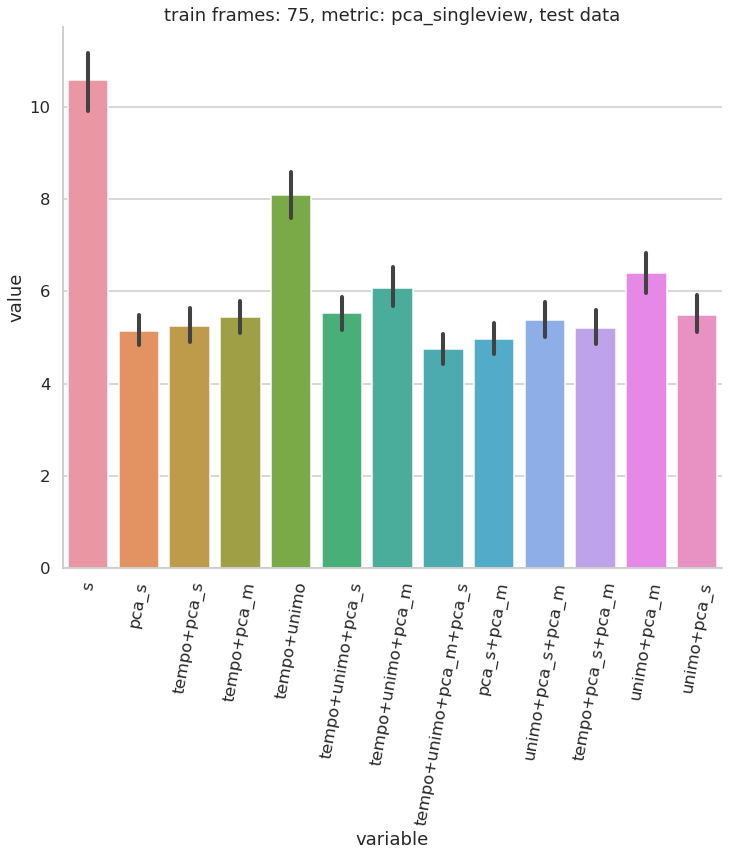

In [130]:
#have multiple columns
sns.set(context='talk', style='whitegrid', font_scale=1, rc = {'figure.figsize':(20,40)})
eval_mode = 'test'

num_losses_to_plot = 16 #len(cols_collected) # can exclude vals here
# average over keypoints and frames
df_tmp_ = df_tmp[df_tmp.eval_mode==eval_mode]
g = sns.catplot(
    data=df_tmp_, x='variable', y='value', kind='bar'
)
# for ax in g.axes:
#     plt.setp(ax.get_yticklabels(), visible=True, rotation=None)
g.set_xticklabels(rotation=80, ha='center')
plt.title("train frames: {}, metric: {}, {} data".format(train_frames, to_compute, eval_mode))
plt.gcf().set_size_inches(15, 10)



/tmp/ipykernel_15441/1208381880.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp__ = df_tmp_[df_tmp["value"]>4.0]


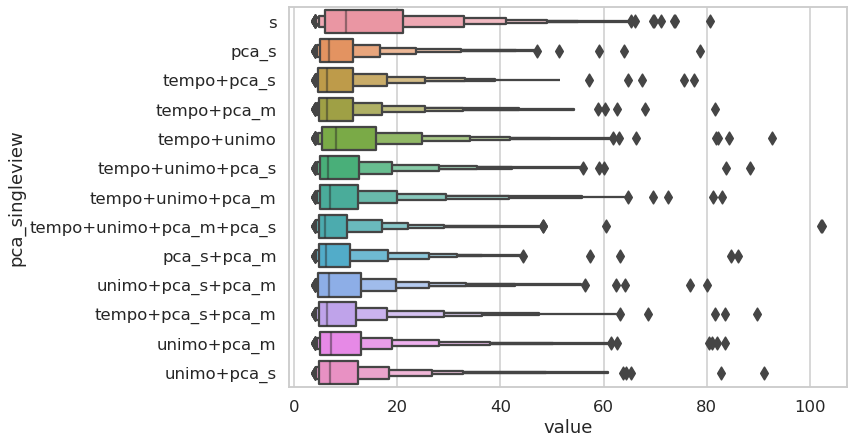

In [131]:
#have multiple columns
sns.set(context='talk', style='whitegrid', font_scale=1, rc = {'figure.figsize':(20,40)})
eval_mode = 'test'
df_tmp_ = df_tmp[df_tmp.eval_mode==eval_mode]
df_tmp__ = df_tmp_[df_tmp["value"]>4.0]
g = sns.boxenplot(
    y='variable', x='value', # switched these around for horizontal boxenplot
    dodge=True,
    data=df_tmp__, 
    orient="h"
)
#g.set_xticklabels(rotation=80, ha='center')
g.set_ylabel(to_compute)
plt.gcf().set_size_inches(10, 7)



In [88]:
df_tmp["value"][df_tmp["value"]<1.0] = 0.0

7         0.751363
9         0.036528
13        0.560154
18        0.720256
25        0.499506
            ...   
228850    0.372508
228851    0.480191
228852    0.605287
228853    0.330290
228854    0.526106
Name: value, Length: 85428, dtype: float64

In [91]:
df_tmp_[df_tmp["value"]>1.0]

/tmp/ipykernel_15441/2034741430.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp_[df_tmp["value"]>1.0]


,bodypart,img_file,eval_mode,variable,value,loss
39,paw1LH_top,barObstacleScaling1/img40.png,test,s,1.155793,
45,paw1LH_top,barObstacleScaling1/img46.png,test,s,16.496723,
52,paw1LH_top,barObstacleScaling1/img53.png,test,s,19.026691,
62,paw1LH_top,barObstacleScaling1/img63.png,test,s,4.453271,
70,paw1LH_top,barObstacleScaling1/img71.png,test,s,29.135069,
...,...,...,...,...,...,...
228579,nose_bot,barObstacleScaling1/img770.png,test,unimo+pca_s,1.069440,unimo+pca
228590,nose_bot,barObstacleScaling1/img781.png,test,unimo+pca_s,1.022395,unimo+pca
228594,nose_bot,barObstacleScaling1/img785.png,test,unimo+pca_s,1.491956,unimo+pca
228807,nose_bot,barObstacleScaling1/img998.png,test,unimo+pca_s,1.146850,unimo+pca
